In [1]:
# necessary imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from sklearn.metrics import *

import scipy.sparse as sparse

from sklearn.feature_selection import RFE
import tqdm

from sklearn.utils.class_weight import compute_class_weight 

import warnings
warnings.filterwarnings('ignore')

## 1. Load the data

In [2]:
df = pd.read_csv('../../Data/final_df.csv', usecols=['Sequence', 'Qualitative_Measure'])
df

,Sequence,Qualitative_Measure
0,DRAHYNIVTFCCKCD,Positive
1,MHGDTPTLHEYM,Positive
2,DSTLRLCVQSTHVD,Positive
3,RNGYRALMDKSLHVGTQCALTRR,Positive
4,SYVLEGTLTAEKTTLVVKEG,Positive
...,...,...
11420,AFMGYALPWGQMSFWGATVI,Negative
11421,QKLAPISIMYQISPPLNVSL,Positive
11422,SCSPTFSSDPLTTPPLMLTT,Negative
11423,PLPWALQTTNLPLMAMSSLL,Positive


In [3]:
# making a bag-of-words vector dataframe by converting our sequence information into matrix of tokens
vect = CountVectorizer(ngram_range=(1,3), analyzer='char', min_df=1)
df_nlp = vect.fit_transform(df['Sequence'])

In [4]:
df_nlp

<11425x7985 sparse matrix of type '<class 'numpy.int64'>'
	with 417622 stored elements in Compressed Sparse Row format>

## 2. Performing Feature Selection using RFE

In [5]:
# function to determine the performance of a model during each iteration of RFE
def feature_drop_scorer(rfe, X, y, X_test, y_test, model):
    max_rank = np.max(rfe.ranking_)  
    mean_scores_train = [] 
    std_scores_train = [] 
    mean_scores_val = []
    std_scores_val = []
    mean_scores_test = []
    std_scores_test = []
    
    oversampler = SMOTE(random_state=42)
    
    for i in tqdm.tqdm(range(max_rank+1, 1, -1)):  
        split = StratifiedKFold(n_splits=5)

        scores_train = []
        scores_val = []
        scores_test = []
        for train_idx, val_idx in split.split(X,y): 
            temp = X.loc[:, rfe.ranking_ < i]  
            temp_test = X_test.loc[:, rfe.ranking_ < i]
            X_tr, y_tr = temp.iloc[train_idx], y.iloc[train_idx]
            X_tr, y_tr = oversampler.fit_resample(X_tr, y_tr)
            X_val, y_val = temp.iloc[val_idx], y.iloc[val_idx]

            model.fit(X_tr, y_tr)
            scores_val.append(matthews_corrcoef(y_val, model.predict(X_val)))
            scores_train.append(matthews_corrcoef(y_tr, model.predict(X_tr)))
            scores_test.append(matthews_corrcoef(y_test, model.predict(temp_test)))
            
        

        mean_score_train = np.mean(scores_train)
        std_score_train = np.std(scores_train)
        mean_scores_train.append(mean_score_train)
        std_scores_train.append(std_score_train)
        
        mean_score_val = np.mean(scores_val)
        std_score_val = np.std(scores_val)
        mean_scores_val.append(mean_score_val)
        std_scores_val.append(std_score_val)
        
        mean_score_test = np.mean(scores_test)
        std_score_test = np.std(scores_test)
        mean_scores_test.append(mean_score_test)
        std_scores_test.append(std_score_test)
        
    return mean_scores_train, std_scores_train, mean_scores_val, std_scores_val, mean_scores_test, std_scores_test

In [6]:
# function to get desired number of features from the dataset based on RFE
def get_features(rfe, X, features_required):
    max_rank = np.max(rfe.ranking_)
    for i in range(max_rank+1, 1, -1):
        cols = X.loc[:, rfe.ranking_ < i].columns
        if len(cols) == features_required:
            return cols
        
    return 'Please enter a valid feature number as per combination searched.'

### In order to use our feature drop scorer function we will have to convert the sparse matrix into dataframe.

In [7]:
df_nlp = pd.DataFrame(df_nlp.toarray())
df_nlp.columns = vect.get_feature_names()

In [8]:
df_nlp

,a,aa,aaa,aac,aad,aae,aaf,aag,aah,aai,...,yym,yyn,yyp,yyq,yyr,yys,yyt,yyv,yyw,yyy
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11420,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11421,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11423,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_nlp, df['Qualitative_Measure'], train_size=0.8, stratify = df['Qualitative_Measure'], random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9140, 7985), (9140,), (2285, 7985), (2285,))

In [10]:
# scaling
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [11]:
# oversampling for balancing
oversampler = SMOTE(random_state=42)

X_train_os, y_train_os = oversampler.fit_resample(X_train_scaled, y_train)

In [12]:
# perform RFE
rfe = RFE(LogisticRegression(), n_features_to_select=1000, step=150, verbose=True)

rfe.fit(X_train_os, y_train_os)

Fitting estimator with 7985 features.
Fitting estimator with 7835 features.
Fitting estimator with 7685 features.
Fitting estimator with 7535 features.
Fitting estimator with 7385 features.
Fitting estimator with 7235 features.
Fitting estimator with 7085 features.
Fitting estimator with 6935 features.
Fitting estimator with 6785 features.
Fitting estimator with 6635 features.
Fitting estimator with 6485 features.
Fitting estimator with 6335 features.
Fitting estimator with 6185 features.
Fitting estimator with 6035 features.
Fitting estimator with 5885 features.
Fitting estimator with 5735 features.
Fitting estimator with 5585 features.
Fitting estimator with 5435 features.
Fitting estimator with 5285 features.
Fitting estimator with 5135 features.
Fitting estimator with 4985 features.
Fitting estimator with 4835 features.
Fitting estimator with 4685 features.
Fitting estimator with 4535 features.
Fitting estimator with 4385 features.
Fitting estimator with 4235 features.
Fitting esti

RFE(estimator=LogisticRegression(), n_features_to_select=1000, step=150,
    verbose=True)

In [13]:
mean_scores_train, std_scores_train, mean_scores_val, std_scores_val, mean_scores_test, std_scores_test = feature_drop_scorer(rfe, X_train_scaled, y_train, X_test_scaled, y_test, LogisticRegression())

100%|███████████████████████████████████████████| 48/48 [14:06<00:00, 17.64s/it]


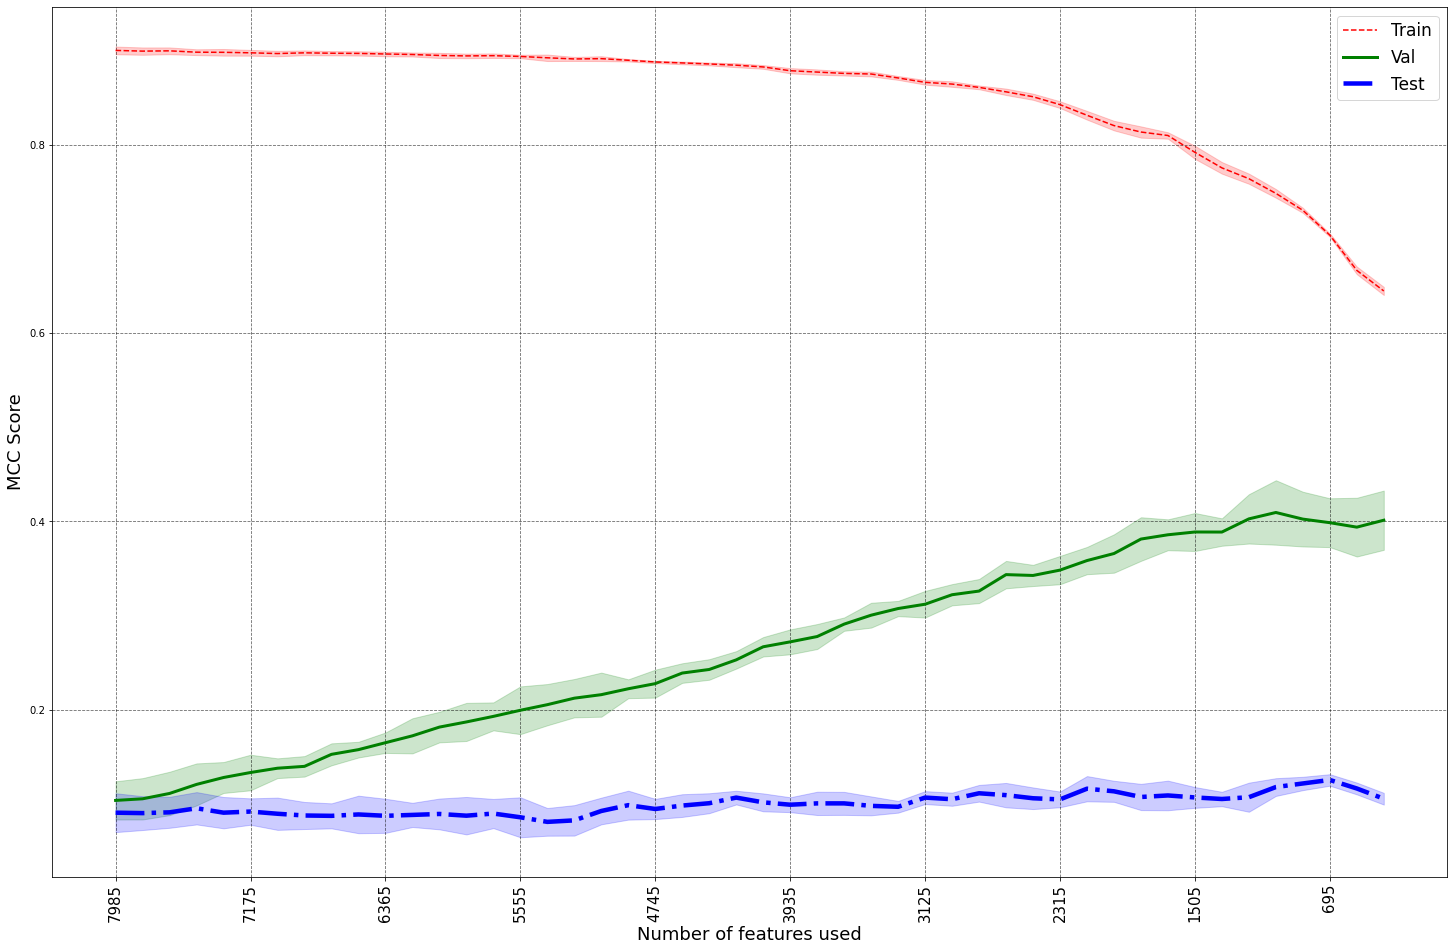

In [14]:
# visualise rfe 
upper_bound_train = np.array(mean_scores_train) + np.array(std_scores_train)
lower_bound_train = np.array(mean_scores_train) - np.array(std_scores_train)
upper_bound_val = np.array(mean_scores_val) + np.array(std_scores_val)
lower_bound_val = np.array(mean_scores_val) - np.array(std_scores_val)
upper_bound_test = np.array(mean_scores_test) + np.array(std_scores_test)
lower_bound_test = np.array(mean_scores_test) - np.array(std_scores_test)


plt.figure(figsize=(25, 16))
plt.plot(mean_scores_train, label='Train', color='r', linewidth=1.5, linestyle='--')
plt.plot(mean_scores_val, label='Val', color='g', linewidth=3)
plt.plot(mean_scores_test, label='Test', color='b', linewidth=4.5, linestyle='-.')
plt.fill_between(range(0, np.unique(rfe.ranking_)[-1], 1), y1=lower_bound_train, y2=upper_bound_train, alpha=0.2, color='r')
plt.fill_between(range(0, np.unique(rfe.ranking_)[-1], 1), y1=lower_bound_val, y2=upper_bound_val, alpha=0.2, color='g')
plt.fill_between(range(0, np.unique(rfe.ranking_)[-1], 1), y1=lower_bound_test, y2=upper_bound_test, alpha=0.2, color='b')
plt.grid(alpha=0.6, color='k', linestyle='--')
plt.xticks(ticks=range(0, np.unique(rfe.ranking_)[-1], 5), labels=range(len(X_train.columns), 0, -810), rotation=90, fontsize=15)
plt.ylabel('MCC Score', fontsize=18)
plt.xlabel('Number of features used', fontsize=18)
plt.legend(fontsize=17)
plt.show()

**And here we see that even on performing Feature Selection, even though the validation score goes up, the test score still remains constantly low.**

**Let's get to dropping the features now**

In [15]:
features_to_keep = get_features(rfe,X_train_os,1000)

In [16]:
features_to_drop = [i for i in X_train_os.columns if i not in features_to_keep]

## 3. Preparing the dataset for Machine Learning

In [17]:
df_nlp.drop(columns=features_to_drop, inplace=True)
df_nlp

,aam,aar,ace,acs,adm,adn,adr,adv,ady,aea,...,yvk,yvl,yvm,yvq,ywi,ywt,yya,yyd,yyk,yym
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# let's convert the dataset back into sparse matrix
df_nlp = sparse.csr_matrix(df_nlp.values)

In [19]:
X = df_nlp
y = df['Qualitative_Measure']

# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify = y, random_state=42)

# scaling
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# oversampling for balancing scaled dataset
X_train_sc_os, y_train_os = oversampler.fit_resample(X_train_scaled, y_train)

# oversampling for balancing unscaled dataset
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

In [20]:
# also calculate class weights
classes = np.unique(y_train.to_numpy())
weights = compute_class_weight(class_weight='balanced', classes=classes, y = y_train)
class_weights = dict(zip(classes, weights))

In [21]:
class_weights

{'Negative': 0.6584065696585506, 'Positive': 2.078217371532515}

In [22]:
# making our own scorer function for GridSearchCV
def matthews_correlation(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    mcc = (tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
    
    return mcc

mcc = make_scorer(matthews_correlation, greater_is_better=True)

### 1. LogisticRegression

In [23]:
# using class weights
logreg = LogisticRegression(class_weight=class_weights)

param_grid_lr = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]}

stratified = StratifiedKFold()

gridlr = GridSearchCV(logreg, param_grid_lr, cv=stratified, scoring=mcc, return_train_score=True, n_jobs=-1)

gridlr.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight={'Negative': 0.6584065696585506,
                                                        'Positive': 2.078217371532515}),
             n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7,
                               1]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [24]:
pd.DataFrame(gridlr.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

,params,mean_train_score,mean_test_score
8,{'C': 1},0.576829,0.432466
7,{'C': 0.7},0.568827,0.430798
6,{'C': 0.5},0.559058,0.423007
5,{'C': 0.3},0.544484,0.412516
4,{'C': 0.1},0.502017,0.376754
3,{'C': 0.01},0.440164,0.318946
2,{'C': 0.001},0.424988,0.309340
1,{'C': 0.0001},0.393046,0.284375
0,{'C': 1e-05},0.267598,0.180583


In [25]:
# saving the best model
modellr = gridlr.best_estimator_
modellr

LogisticRegression(C=1,
                   class_weight={'Negative': 0.6584065696585506,
                                 'Positive': 2.078217371532515})

In [26]:
# evaluating the performance
print(f"The confusion matrix:\n{confusion_matrix(y_test,modellr.predict(X_test_scaled))}")
print(f"MCC score is:\n{matthews_corrcoef(y_test, modellr.predict(X_test_scaled))}")

The confusion matrix:
[[1224  511]
 [ 317  233]]
MCC score is:
0.11779028202549034


In [27]:
# using oversampled data
logreg = LogisticRegression()

gridlr2 = GridSearchCV(logreg, param_grid_lr, cv=stratified, scoring=mcc, return_train_score=True, n_jobs=-1)

gridlr2.fit(X_train_sc_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7,
                               1]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [28]:
pd.DataFrame(gridlr2.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

,params,mean_train_score,mean_test_score
8,{'C': 1},0.644024,0.580458
7,{'C': 0.7},0.635137,0.574841
6,{'C': 0.5},0.625893,0.566685
5,{'C': 0.3},0.610375,0.556919
4,{'C': 0.1},0.567361,0.521197
3,{'C': 0.01},0.491020,0.447599
2,{'C': 0.001},0.466513,0.426328
1,{'C': 0.0001},0.458106,0.418260
0,{'C': 1e-05},0.443538,0.402963


In [29]:
modellr2 = gridlr2.best_estimator_
modellr2

LogisticRegression(C=1)

In [30]:
# evaluating the performance
print(f"The confusion matrix:\n{confusion_matrix(y_test,modellr2.predict(X_test_scaled))}")
print(f"MCC score is:\n{matthews_corrcoef(y_test, modellr2.predict(X_test_scaled))}")

The confusion matrix:
[[1159  576]
 [ 300  250]]
MCC score is:
0.10905647907337782


We can see that upon performing feature selection, the performance has improved on the oversampled dataset but has decreased for when we are using class weights to deal with class imbalance.

But overall, no noteworthy difference.

### 2. NaiveBayes

In [43]:
# training the model
nb = MultinomialNB()

nb.fit(X_train_os, y_train_os)

# testing the performance
print(f"Confusion matrix for NB:\n {confusion_matrix(y_test, nb.predict(X_test))}")
print(f"MCC score for NB: {matthews_corrcoef(y_test, nb.predict(X_test))}")

Confusion matrix for NB:
 [[1154  581]
 [ 304  246]]
MCC score for NB: 0.09999428780625963


### 3. SupportVectorClassifier

In [32]:
# training the model
svc = SVC(class_weight=class_weights, probability=True)

param_grid_svc = {'C':[0.1,10,100],
              'gamma':[0.001,0.01,0.1,10,100]}

gridsvc = GridSearchCV(svc, param_grid_svc, scoring=mcc, n_jobs=-1, cv=stratified, return_train_score=True)

gridsvc.fit(X_train_scaled, y_train)

/tmp/ipykernel_13493/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13493/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13493/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13493/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13493/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13493/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13493/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13493/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13493/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13493/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13493/2626833026.py:5: RuntimeWarni

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(class_weight={'Negative': 0.6584065696585506,
                                         'Positive': 2.078217371532515},
                           probability=True),
             n_jobs=-1,
             param_grid={'C': [0.1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 10, 100]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [33]:
pd.DataFrame(gridsvc.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
11,"{'C': 100, 'gamma': 0.01}",0.607257,0.429139
10,"{'C': 100, 'gamma': 0.001}",0.534944,0.411544
6,"{'C': 10, 'gamma': 0.01}",0.534907,0.409014
7,"{'C': 10, 'gamma': 0.1}",0.662990,0.407010
12,"{'C': 100, 'gamma': 0.1}",0.725792,0.339253
5,"{'C': 10, 'gamma': 0.001}",0.399853,0.274115
2,"{'C': 0.1, 'gamma': 0.1}",0.266088,0.162044
8,"{'C': 10, 'gamma': 10}",0.772975,0.111940
13,"{'C': 100, 'gamma': 10}",0.773452,0.110705
9,"{'C': 10, 'gamma': 100}",0.773142,0.081250


In [34]:
modelsvc = gridsvc.best_estimator_
modelsvc

SVC(C=100,
    class_weight={'Negative': 0.6584065696585506,
                  'Positive': 2.078217371532515},
    gamma=0.01, probability=True)

In [35]:
# evaulating model performance
print(f"Confusion matrix for SVC:\n {confusion_matrix(y_test, modelsvc.predict(X_test_scaled))}")
print(f"Matthews correlation coefficient for SVC: {matthews_corrcoef(y_test, modelsvc.predict(X_test_scaled))}")

Confusion matrix for SVC:
 [[1224  511]
 [ 311  239]]
Matthews correlation coefficient for SVC: 0.12747919433975669


### 4. RandomForestClassifier

In [36]:
# training the model with default parameters
rfc = RandomForestClassifier()

rfc.fit(X_train_os, y_train_os)

# evaluating the performance
matthews_corrcoef(y_test, rfc.predict(X_test))

0.045862322753918015

In [37]:
# let's use gridsearchcv for the best parameter and also to look at the cross validation performance
rfc = RandomForestClassifier()

param_grid_rfc = {'n_estimators':[100,200,300,400,500,600,1000],
                  'max_depth':[3,5,7],
                  'max_features':[0.5,0.6,0.7,0.8,0.9]}

gridrfc = GridSearchCV(rfc, param_grid_rfc, scoring=mcc, n_jobs=-1, cv=stratified, return_train_score=True)

gridrfc.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 1000]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [38]:
pd.DataFrame(gridrfc.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
96,"{'max_depth': 7, 'max_features': 0.8, 'n_estim...",0.293468,0.258682
73,"{'max_depth': 7, 'max_features': 0.5, 'n_estim...",0.295386,0.256365
71,"{'max_depth': 7, 'max_features': 0.5, 'n_estim...",0.292415,0.256185
87,"{'max_depth': 7, 'max_features': 0.7, 'n_estim...",0.293343,0.256087
93,"{'max_depth': 7, 'max_features': 0.8, 'n_estim...",0.295014,0.255713
...,...,...,...
14,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.208481,0.190918
33,"{'max_depth': 3, 'max_features': 0.9, 'n_estim...",0.209275,0.190885
21,"{'max_depth': 3, 'max_features': 0.8, 'n_estim...",0.205302,0.189025
22,"{'max_depth': 3, 'max_features': 0.8, 'n_estim...",0.209751,0.187285


In [39]:
# saving the best model
modelrfc = gridrfc.best_estimator_
modelrfc

RandomForestClassifier(max_depth=7, max_features=0.8, n_estimators=600)

In [40]:
# evaulating model performance
print(f"Confusion matrix for RFC:\n {confusion_matrix(y_test, modelrfc.predict(X_test))}")
print(f"Matthews correlation coefficient for RFC: {matthews_corrcoef(y_test, modelrfc.predict(X_test))}")

Confusion matrix for RFC:
 [[ 424 1311]
 [ 105  445]]
Matthews correlation coefficient for RFC: 0.05419532652922151


## AU-ROC for all the models

In [41]:
print(f"AU-ROC score for LR is: {roc_auc_score(y_test, modellr.predict_proba(X_test_scaled)[:,1])}")
print(f"AU-ROC score for NB is: {roc_auc_score(y_test, nb.predict_proba(X_test)[:,1])}")
print(f"AU-ROC score for SVC is: {roc_auc_score(y_test, modelsvc.predict_proba(X_test_scaled)[:,1])}")
print(f"AU-ROC score for RFC is: {roc_auc_score(y_test, modelrfc.predict_proba(X_test)[:,1])}")

AU-ROC score for LR is: 0.5910992926381975
AU-ROC score for NB is: 0.5914435420487294
AU-ROC score for SVC is: 0.5905632695834424
AU-ROC score for RFC is: 0.5544086979303118


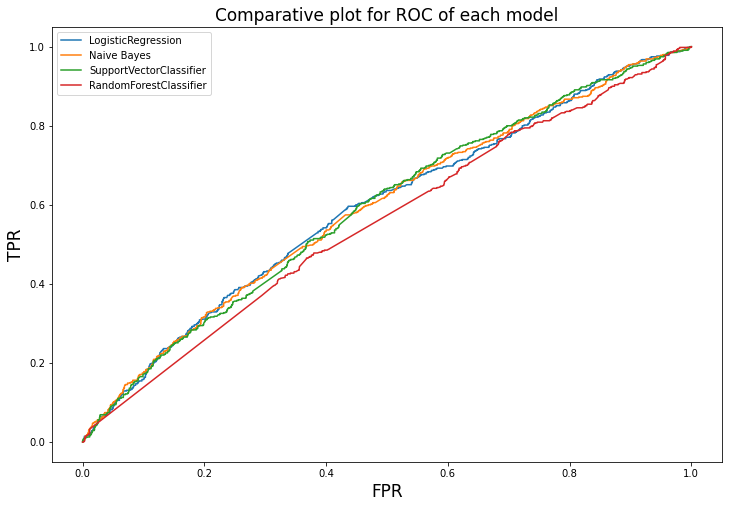

In [42]:
# plotting the ROCs for each model
fpr1, tpr1, threshold1 = roc_curve(y_test, modellr.predict_proba(X_test_scaled)[:,1], pos_label='Positive')
fpr2, tpr2, threshold2 = roc_curve(y_test, nb.predict_proba(X_test)[:,1], pos_label='Positive')
fpr3, tpr3, threshold3 = roc_curve(y_test, modelsvc.predict_proba(X_test)[:,1], pos_label='Positive')
fpr4, tpr4, threshold4 = roc_curve(y_test, modelrfc.predict_proba(X_test)[:,1], pos_label='Positive')

plt.figure(figsize=(12,8))
plt.plot(fpr1,tpr1,label='LogisticRegression')
plt.plot(fpr2,tpr2,label='Naive Bayes')
plt.plot(fpr3,tpr3,label='SupportVectorClassifier')
plt.plot(fpr4,tpr4,label='RandomForestClassifier')

plt.xlabel('FPR', fontsize=17)
plt.ylabel('TPR', fontsize=17)
plt.title('Comparative plot for ROC of each model', fontsize=17)
plt.legend()
plt.show()

All the models have almost the same AU-ROC and again RFC seems to be performing the worst with the most random predictions.

### <font color='palevioletred'>CONCLUSION</font> 
**Even on performing Feature Selection we did not see any significant improvement in the performance.**

**Next we can try to reduce the dimensionality of the dataset using Principal Component Analysis and see if that allows some improvement**